In [1]:
import symd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
base_colors = ["f94144","f3722c","f8961e","f9844a","f9c74f","90be6d","43aa8b","4d908e","577590","277da1"]    
colors = ['#' + c for c in base_colors]

In [2]:
def run_sim(n, cell, group, w=None, retries=5, pos_frames=0):
    for _ in range(retries):
        try:
            md = symd.Symd(nparticles=n, cell=cell, ndims=2, images=2, force='lj', wyckoffs=w,
              group=group, steps=30000, exeDir='sim', start_temperature=0.5)
            md.remove_overlap()
            md.shrink()
            if pos_frames > 0:
                md.log_positions(frames=pos_frames)
            md.log_output(period = int(1 / md.runParams['time_step']))
            md.run()
            break
        except RuntimeError as e:
            print(e)
            md = None
    return md

In [4]:
np.random.seed(0)
md = run_sim(5, [20, 20], 17, pos_frames=100)

Shrunk from 1385.64 to 1028.87
New cell: [34.2202, -17.1101, 0.0, 29.6356]


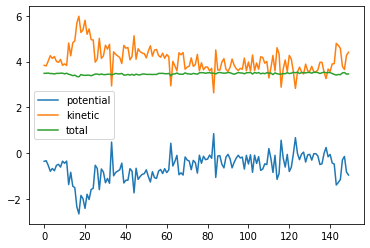

In [5]:
plt.plot(md.pe, label='potential')
plt.plot(md.ke, label='kinetic')
plt.plot(md.te, label='total')
plt.legend(loc='best')

## All Sims

In [5]:
titles = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
df = pd.DataFrame()
retries = 3
def smooth(x):
    window = int(np.ceil(len(x) / 10.0))
    weights = np.ones(window)
    energy_smooth = np.convolve(
        weights / weights.sum(), x[(window + 1):], mode="valid"
    )
    return x

def standardize(te):
    i = int(md.te.shape[0] * 0.2)
    te = md.te[i:]
    return te - np.mean(te)

for i,t in enumerate(titles):    
    md = run_sim(4, [20, 20], i+1)
    df = df.assign(**{t: standardize(md.te)})    

Shrunk from 400.268 to 362.49
New cell: [18.6532, 0.0, 0.0, 19.3407]
Shrunk from 400.268 to 362.49
New cell: [18.6532, 0.0, 0.0, 19.3407]
Shrunk from 400.268 to 363.277
New cell: [18.7116, 0.0, 0.0, 19.3231]
Shrunk from 400.268 to 362.49
New cell: [18.6532, 0.0, 0.0, 19.3407]
Shrunk from 400.268 to 362.748
New cell: [18.6347, 0.0, 0.0, 19.3571]
{"steps": 1000, "n_particles": 4, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 10, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.01, "pressure": null, "box_update_period": 0, "start_temperature": 0.5, "thermostat": "baoab", "force_type": "lj", "final_positions": "sim/group-6.xyz", "cell_log_file": "sim/cell_log_file.dat", "print_period": 300.0, "cell": [20, 20], "lj_epsilon": 1, "lj_sigma": 1.0, "n_images": 2, "start_positions": "sim/group-6.xyz", "group": "sim/group-6.json"}
Info: You are running version 9366-dirty of symd
Assuming you'll pass parameters via st

In [ ]:
fig = plt.figure(figsize=(4,5))
ax = plt.gca()
mx = df.shape[0] // 2
for i,n in enumerate(df.columns):
    color = colors[i % len(base_colors)]
    ax.plot(df[n] + i, color=color)
    offsetbox = mpl.offsetbox.TextArea(n)
    #mx = (df.shape[0] - 1) * (i / df.shape[1])
    #if i % 2 == 0:
    #    mx = df.shape[0] - mx - 1
    ab = mpl.offsetbox.AnnotationBbox(offsetbox, (mx,df[n][mx] + i),
                    xybox=(mx,df[n][mx] + i),
                    xycoords='data',
                    boxcoords='data',
                    arrowprops=None,
                    bboxprops=dict(fc="#f5f4e9", lw=0))
    ax.add_artist(ab)
ax.set_xlabel('Time [$\tau$]')
ax.set_facecolor('#f5f4e9')
ax.set_ylabel('$\Delta$ Energy [$\epsilon$]')
plt.savefig('energy.svg')

## Atlas

In [6]:
def scale(x, ib):
    s = np.apply_along_axis(lambda xi: ib @ xi, 1, x)
    return np.fmod(s, 1.0)

def compute_symm(positions, gnum, cell, ndim, n):
    group = symd.groups.load_group(gnum, ndim)
    cell = np.array(cell).reshape(ndim,ndim)
    ib = np.linalg.inv(cell)
    s = scale(positions[:,:ndim], ib)    
    members = [symd.groups.str2mat(e) for e in group['genpos']]
    folded_positions = np.zeros_like(s)
    for i in range(n):
        folded_positions[i,:] = s[i,:]
        for j in range(1, len(members)):
            k = j * n + i
            im = np.linalg.inv(members[j])
            w = im[:ndim, :ndim]            
            folded_positions[i,:] += w @ s[k] + im[ndim, :ndim]
        folded_positions[i, :] /= len(members)
        for j in range(1, len(members)):
            k = j * n + i
            w = members[j][:ndim, :ndim]            
            folded_positions[k] = w @ folded_positions[i] + members[j][ndim, :ndim]    
    return np.mean((s[:k] - folded_positions[:k])**2)
def rmsd(p1, p2):
    return np.mean((p1 - p2)**2, axis=(1,2))

In [123]:
def crystal(n, cell, group, w=None, retries=5, steps=10**5, ndims=2):
    for _ in range(retries):
        try:
            # NPT
            md = symd.Symd(nparticles=n, cell=cell, ndims=ndims, images=2, force='lj', wyckoffs=w,
              group=group, steps=steps, exeDir='crystal', pressure=1.0, temperature=0.05, start_temperature=0.1)
            md.remove_overlap()
            md.shrink()
            md.log_positions()
            md.run()
            
            # NVT
            md.runParams['temperature'] = 0.05
            md.runParams['Pressure'] = None
            md.runParams['steps'] = steps // 4
            #md.run()
            config = md.positions[-1]            
            
            # Stability
            fp = np.loadtxt(md.runParams['final_positions'])
            cell = md.read_cell()
            m = fp.shape[0]
            md2 = symd.Symd(nparticles=m, cell=cell, ndims=2, images=2, force='lj', wyckoffs=None,
              group=1, steps=2 * 1500, exeDir='melt', temperature=None, start_temperature=0)
            # run once to get melting traj
            # then again for longer with longer period
            md2.log_positions(period=2)
            md2.runParams['start_positions'] = md.runParams['final_positions']            
            md2.run()
            traj = md2.positions
            md2.runParams['steps'] = steps // 4
            md2.log_positions(period=int(1 / md2.runParams['time_step']))
            #md2.run()
            #csm = rmsd(md2.positions[:,:m], config[:m])
            csm = []
            for i in range(md2.positions.shape[0]):
                csm.append(compute_symm(md2.positions[i], group, md2.read_cell(), ndims, n))
            break
        except RuntimeError as e:
            print(e)
    return config, md2.positions[-1], csm, traj

In [124]:
config, config2, csm, traj = crystal(6, [20, 20], 17, w=1)

Shrunk from 1384.92 to 1104.95
New cell: [34.5215, -17.2608, 0.0, 29.8965]
{"steps": 100000, "n_particles": 6, "time_step": 0.005, "seed": 435423, "anderson_nu": 100, "langevin_gamma": 0.1, "bussi_taut": 0.5, "thermostat_seed": 54344, "rcut": 10, "skin": 0.6000000000000001, "temperature": 0.05, "pressure": 1.0, "box_update_period": 5, "start_temperature": 0.05, "thermostat": "baoab", "force_type": "lj", "final_positions": "crystal/final_positions.dat", "cell_log_file": "crystal/cell_log_file.dat", "print_period": 1000.0, "cell": [34.5215, -17.2608, 0.0, 29.8965], "lj_epsilon": 1, "lj_sigma": 1, "n_images": 2, "start_positions": "crystal/group-17.dat", "group": "crystal/group-17.json", "wyckoffs": [{"group": "crystal/group-17-00.json", "n_particles": 1}, {"group": "crystal/group-17-01.json", "n_particles": 1}, {"group": "crystal/group-17-02.json", "n_particles": 1}, {"group": "crystal/group-17-03.json", "n_particles": 1}, {"group": "crystal/group-17-04.json", "n_particles": 1}], "positi

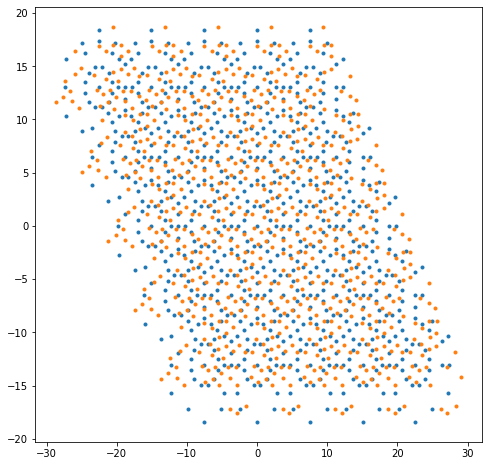

In [125]:
plt.figure(figsize=(8, 8))
plt.plot(config[:,0], config[:,1], '.')
plt.plot(config2[:,0], config2[:,1], '.')

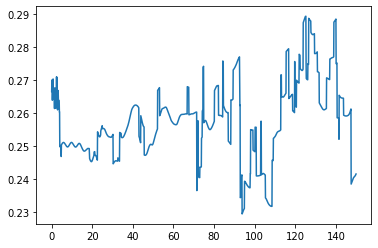

In [127]:
plt.plot(np.arange(len(csm)) / 10, csm)

In [ ]:
for i,t in enumerate(titles):    
    print(t)
    md = run_sim(4, [20, 20], i+1)
    df = df.assign(**{t: standardize(md.te)})    
    continue
    wycks = len(symd.groups.load_group(i+1, 2)['specpos'])    
    for j in range(wycks):
        md = run_sim(4+j+1, [20, 20], i+1, w=[1] * (j+1))
        name = f'{t}-w{j}'
        if md is None:
            print(name, 'failed')
            continue
        df = df.assign(**{name: standardize(md.te)})

## Movie

In [65]:
# make a movie
import moviepy.editor as editor
from moviepy.video.io.bindings import mplfig_to_npimage


def plot(traj, title='@_172135352171_', color='#333333', fps=60):
    T, N, D = traj.shape    
    fps = fps
    duration = T / fps
    dpi = 90
    fig, ax = plt.subplots(figsize=(1200 / dpi, 800 / dpi), dpi=dpi)    
    points = ax.plot(traj[0,:,0], traj[0,:,1], color=color, marker='o', markeredgewidth=0.0, linestyle='None', alpha=1.0)[0]
    ax.set_facecolor('#f5f4e9')
    fig.patch.set_facecolor('#f5f4e9')
    title = ax.set_title(title, fontsize=32, color='#333333',fontname='monospace')
    ax.axis('off')
    xlim = np.quantile(traj[:,:,0], [0.3, 0.8])
    ylim = np.quantile(traj[:,:,1], [0.3, 0.8])
    ax.set_aspect('equal')    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    #plt.tight_layout()
    def make_frame(t):
        i = int(t  * fps)
        i = min(i, T-1)
        points.set_data(traj[i,:,0], traj[i,:,1])    
        return mplfig_to_npimage(fig)

    return editor.VideoClip(make_frame, duration=duration)
def write_video(clips, output, fps=60):
    composite = editor.concatenate(clips[:1] + [c.crossfadein(1.0) for c in clips[1:]], padding=-1, method='compose')   
    composite.write_videofile(output, fps=fps, preset='slower', ffmpeg_params=['-tune', 'animation'])

Moviepy - Building video new.mp4.
Moviepy - Writing video new.mp4



Moviepy - Done !
Moviepy - video ready new.mp4


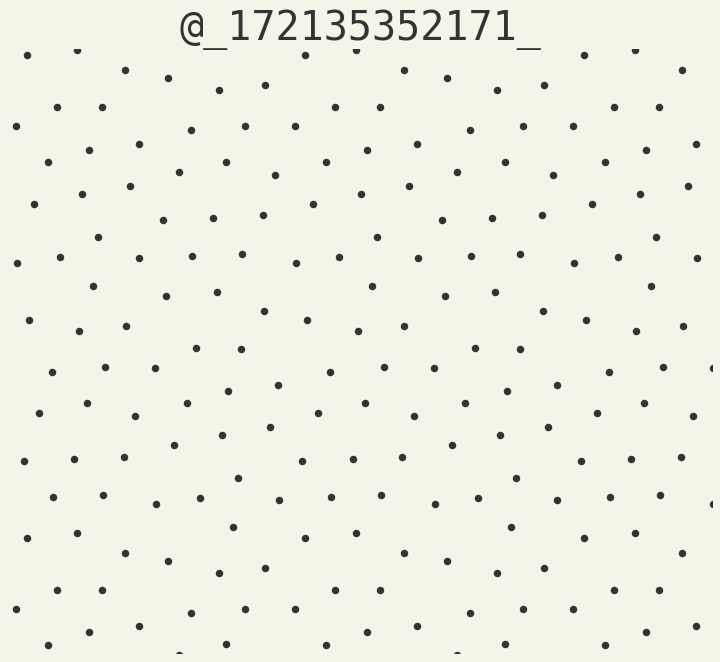

In [122]:
c = plot(traj)
write_video([c], 'new.mp4')

In [ ]:
c = []
titles = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
base_colors = ["f94144","f3722c","f8961e","f9844a","f9c74f","90be6d","43aa8b","4d908e","577590","277da1"]    
colors = ['#' + c for c in base_colors]
for i,t in enumerate(titles):
    md = run_sim(4, [20, 20], i+1)
    color = colors[i % len(colors)]
    c.append(plot(md.positions, t, color))
    wycks = len(symd.groups.load_group(i+1, 2)['specpos'])
    for j in range(wycks):
        try:
            md = run_sim(4+j+1, [20, 20], i+1, w=[1] * (j+1))
            c.append(plot(md.positions, f'{t}-w{j}', color))
        except RuntimeError as e:
            print(e)
write_video(c, 'traj.mp4')
for ci in c:
    ci.close()

In [ ]:
cd = 500 / 60
md = int(135 / cd) * cd
print('Will cut to clips of length', md)
main_clip = editor.VideoFileClip("traj.mp4")
N = int(main_clip.duration / md) + 1
print('Will write', N, 'clips')
time = 0
i = 0
for i in range(N):
    clip = main_clip.subclip(i * md, min((i + 1) * md, main_clip.duration))
    clip.write_videofile(f'traj-{i}.mp4', fps=60)#, preset='slower', ffmpeg_params=['-tune', 'animation'])
    clip.close()
